In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt 
from matplotlib import figure, colors
from matplotlib.patches import Rectangle
import xmltodict
import os
%matplotlib inline
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torchvision.transforms import functional as F

In [3]:
IMG_FOLDER = '/home/keane/git/rsna/annotations/images'
LABEL_FOLDER = '/home/keane/git/rsna/annotations/labels'
NEW_LABEL_FOLDER = '/home/keane/git/rsna/annotations/labels_new'

### Preprocessing

In [121]:
def get_label(label_file):
    with open(label_file) as fd:
        doc = xmltodict.parse(fd.read())
        return doc
        #return [x for x in doc['annotation']['object']]        

def get_img_and_label(img_folder, label_folder, idx = 0):
    imgs = list(sorted(os.listdir(img_folder)))
    labels = list(sorted(os.listdir(label_folder)))
    img = Image.open(os.path.join(img_folder,imgs[idx])).convert("RGB")
    label = get_label(os.path.join(label_folder, labels[idx]))
    return img, label

def visualize_raw(img,label):
    fig,ax = plt.subplots(figsize = (20,10))
    ax.imshow(img)
    for i,box in enumerate(label['annotation']['object']):
        vertices = box['bndbox']
        name = box['name']
        xmin, ymin, xmax, ymax =[int(x) for x in vertices.values()]
        norm = colors.Normalize(vmin=-5, vmax=5)
        cmap = plt.cm.rainbow
        ax.add_patch(Rectangle((xmin,ymin), xmax- xmin,ymax-ymin, alpha = 0.2))
        plt.text((xmin + xmax)/2, (ymin + ymax)/2,name)
    
def manual_map_img(label_path, new_label_path):
    # This will update the labels in the repo to match the challenge
    with open(label_path) as fd:
        doc = xmltodict.parse(fd.read())
    label = doc['annotation']['object']  
    label = [bb for bb in label if bb['name'] != 'DIP']
    Wrist = [float(bb['bndbox']['xmin'])/2 + float(bb['bndbox']['xmax'])/2 for bb in label if bb['name'] == 'Wrist'].pop()
    Ulna = [float(bb['bndbox']['xmin'])/2 + float(bb['bndbox']['xmax'])/2 for bb in label if bb['name'] == 'Ulna'].pop()
    left = Wrist > Ulna
    if not left:
        print(label_path)
    pips = {i:(float(bb['bndbox']['xmin'])/2 + float(bb['bndbox']['xmax'])/2) for i,bb in enumerate(label) if bb['name'] == 'PIP'}
    pips = sorted(pips, key = lambda i: pips[i], reverse = left)
    for i,pip in enumerate(pips):
        label[pip]['name'] = ('LH' if left else 'RH') + '_pip_' +str(i+1) 
        
    mcps = {i:(float(bb['bndbox']['xmin'])/2 + float(bb['bndbox']['xmax'])/2) for i,bb in enumerate(label) if bb['name'] == 'MCP'}
    mcps = sorted(mcps, key = lambda i: mcps[i], reverse = left)
    for i,mcp in enumerate(mcps):
        label[mcp]['name'] = ('LH' if left else 'RH') + '_mcp_' +str(i+1)
    label = [bb for bb in label if not(bb['name'].endswith('pip_1'))]
    doc['annotation']['object']  = label   
    with open(new_label_path, 'w') as result_file:
        result_file.write(xmltodict.unparse(doc))
    
def manual_map(label_folder, new_label_folder):
    if not os.path.exists(new_label_folder):
        os.mkdir(new_label_folder)
    label_paths = os.listdir(label_folder)
    for idx in range(len(label_paths)):
        manual_map_img(os.path.join(label_folder, label_paths[idx]),os.path.join(new_label_folder, label_paths[idx]))

In [122]:
# Let's manually map the current repo labels to the challenge's labels
manual_map(LABEL_FOLDER, NEW_LABEL_FOLDER);

/home/keane/git/rsna/annotations/labels/4249.xml
/home/keane/git/rsna/annotations/labels/4213.xml
/home/keane/git/rsna/annotations/labels/6407.xml
/home/keane/git/rsna/annotations/labels/4244.xml


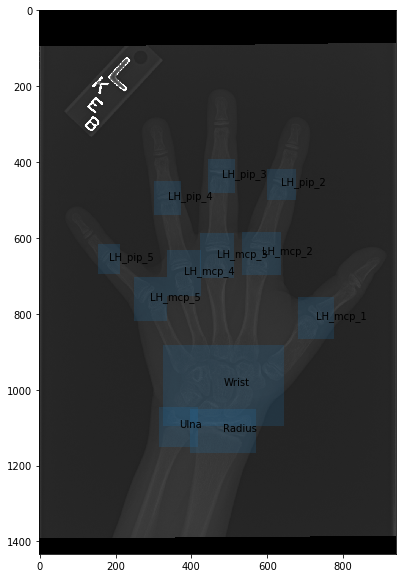

In [120]:
# Now visualize the relabelled data
img,label = get_img_and_label(IMG_FOLDER, NEW_LABEL_FOLDER,idx = 79)
visualize_raw(img, label)

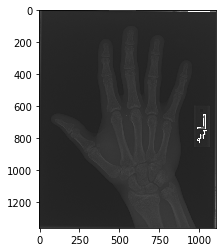

In [116]:
from PIL import ImageOps
plt.imshow(ImageOps.mirror(img))

In [7]:
#Now let's create a map for the names
names = [x['name'] for x in label['annotation']['object']]
names = names + [x.replace('LH', 'RH') for x in names if 'LH' in x]
NAME_TO_ID_MAP = dict(zip(names, range(len(names))))
NAME_TO_ID_MAP

{'LH_pip_5': 0,
 'LH_mcp_1': 1,
 'LH_pip_3': 2,
 'LH_pip_2': 3,
 'LH_pip_4': 4,
 'LH_mcp_2': 5,
 'LH_mcp_4': 6,
 'LH_mcp_3': 7,
 'LH_mcp_5': 8,
 'Wrist': 9,
 'Ulna': 10,
 'Radius': 11,
 'RH_pip_5': 12,
 'RH_mcp_1': 13,
 'RH_pip_3': 14,
 'RH_pip_2': 15,
 'RH_pip_4': 16,
 'RH_mcp_2': 17,
 'RH_mcp_4': 18,
 'RH_mcp_3': 19,
 'RH_mcp_5': 20}

In [20]:
ID_TO_NAME_MAP = {NAME_TO_ID_MAP[key]:key for key in NAME_TO_ID_MAP}

### Set up

In [8]:
class RADataSet(torch.utils.data.Dataset):
    def __init__(self, img_folder, label_folder = None, transforms=None):
        self.transforms = transforms
        self.img_folder = img_folder
        self.imgs = list(sorted(os.listdir(self.img_folder)))
        self.manual_map = manual_map
        if label_folder:
            self.label_folder = label_folder
            self.labels = list(sorted(os.listdir(self.label_folder)))

    def __getitem__(self, idx):
        # load images ad masks
        img = Image.open(os.path.join(self.img_folder,self.imgs[idx])).convert("RGB")
        target = {}
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        if hasattr(self, "label_folder"):
            label = get_label(os.path.join(self.label_folder, self.labels[idx]))
        
            # get bounding box coordinates for each mask
            num_objs = len(label['annotation']['object'])
            boxes = []
            for bb in label['annotation']['object']:
                xmin,ymin,xmax,ymax = bb['bndbox'].values()
                boxes.append([int(xmin), int(ymin), int(xmax), int(ymax)])
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            ids = torch.as_tensor([NAME_TO_ID_MAP[bb['name']] for bb in label['annotation']['object']], dtype=torch.int64)
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target["boxes"] = boxes
            target["labels"] = ids
        #target["area"] = area
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)
    

In [9]:
#dataset = RADataSet(IMG_FOLDER,NEW_LABEL_FOLDER)

In [10]:
#img, target = dataset[5]

### Model

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [12]:
from engine import train_one_epoch, evaluate
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    #if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [13]:
import utils
dataset = RADataSet(IMG_FOLDER,NEW_LABEL_FOLDER,get_transform(train=True))
ra2_dataset = RADataSet('/home/keane/git/ra2challenge/train',None,get_transform(train=True))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

data_loader_test_ra2 = torch.utils.data.DataLoader(
    ra2_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(NAME_TO_ID_MAP)

model = get_instance_segmentation_model(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [90]:
# let's train it for 10 epochs
num_epochs = 20
from engine import train_one_epoch

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/100]  eta: 0:01:12  lr: 0.000055  loss: 0.1398 (0.1398)  loss_classifier: 0.0692 (0.0692)  loss_box_reg: 0.0496 (0.0496)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0202 (0.0202)  time: 0.7283  data: 0.2065  max mem: 2962
Epoch: [0]  [ 10/100]  eta: 0:00:48  lr: 0.000560  loss: 0.1398 (0.1430)  loss_classifier: 0.0692 (0.0673)  loss_box_reg: 0.0484 (0.0492)  loss_objectness: 0.0007 (0.0012)  loss_rpn_box_reg: 0.0257 (0.0253)  time: 0.5422  data: 0.0256  max mem: 2962
Epoch: [0]  [ 20/100]  eta: 0:00:43  lr: 0.001065  loss: 0.1276 (0.1360)  loss_classifier: 0.0651 (0.0660)  loss_box_reg: 0.0421 (0.0447)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0231 (0.0241)  time: 0.5288  data: 0.0077  max mem: 2962
Epoch: [0]  [ 30/100]  eta: 0:00:37  lr: 0.001569  loss: 0.1216 (0.1349)  loss_classifier: 0.0639 (0.0651)  loss_box_reg: 0.0375 (0.0445)  loss_objectness: 0.0006 (0.0012)  loss_rpn_box_reg: 0.0229 (0.0241)  time: 0.5238  data: 0.0084  max mem: 2962


Epoch: [3]  [  0/100]  eta: 0:01:23  lr: 0.000500  loss: 0.1476 (0.1476)  loss_classifier: 0.0570 (0.0570)  loss_box_reg: 0.0508 (0.0508)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0384 (0.0384)  time: 0.8353  data: 0.3166  max mem: 2962
Epoch: [3]  [ 10/100]  eta: 0:00:51  lr: 0.000500  loss: 0.1186 (0.1260)  loss_classifier: 0.0574 (0.0577)  loss_box_reg: 0.0397 (0.0412)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0240 (0.0260)  time: 0.5683  data: 0.0366  max mem: 2962
Epoch: [3]  [ 20/100]  eta: 0:00:44  lr: 0.000500  loss: 0.1160 (0.1237)  loss_classifier: 0.0574 (0.0584)  loss_box_reg: 0.0364 (0.0397)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0228 (0.0243)  time: 0.5377  data: 0.0087  max mem: 2962
Epoch: [3]  [ 30/100]  eta: 0:00:37  lr: 0.000500  loss: 0.1068 (0.1183)  loss_classifier: 0.0517 (0.0566)  loss_box_reg: 0.0312 (0.0371)  loss_objectness: 0.0008 (0.0012)  loss_rpn_box_reg: 0.0215 (0.0234)  time: 0.5276  data: 0.0083  max mem: 2962


Epoch: [6]  [  0/100]  eta: 0:01:30  lr: 0.000050  loss: 0.0818 (0.0818)  loss_classifier: 0.0402 (0.0402)  loss_box_reg: 0.0255 (0.0255)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0157 (0.0157)  time: 0.9027  data: 0.3909  max mem: 2962
Epoch: [6]  [ 10/100]  eta: 0:00:50  lr: 0.000050  loss: 0.0933 (0.0931)  loss_classifier: 0.0476 (0.0474)  loss_box_reg: 0.0255 (0.0268)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0184 (0.0184)  time: 0.5569  data: 0.0403  max mem: 2962
Epoch: [6]  [ 20/100]  eta: 0:00:43  lr: 0.000050  loss: 0.0921 (0.0920)  loss_classifier: 0.0452 (0.0470)  loss_box_reg: 0.0247 (0.0254)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0184 (0.0187)  time: 0.5206  data: 0.0064  max mem: 2962
Epoch: [6]  [ 30/100]  eta: 0:00:37  lr: 0.000050  loss: 0.0912 (0.0948)  loss_classifier: 0.0468 (0.0487)  loss_box_reg: 0.0247 (0.0263)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0190 (0.0190)  time: 0.5268  data: 0.0074  max mem: 2962


Epoch: [9]  [  0/100]  eta: 0:01:12  lr: 0.000005  loss: 0.0858 (0.0858)  loss_classifier: 0.0411 (0.0411)  loss_box_reg: 0.0245 (0.0245)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0184 (0.0184)  time: 0.7254  data: 0.2361  max mem: 2962
Epoch: [9]  [ 10/100]  eta: 0:00:51  lr: 0.000005  loss: 0.0858 (0.0873)  loss_classifier: 0.0461 (0.0445)  loss_box_reg: 0.0245 (0.0248)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0180 (0.0174)  time: 0.5745  data: 0.0283  max mem: 3072
Epoch: [9]  [ 20/100]  eta: 0:00:43  lr: 0.000005  loss: 0.0879 (0.1096)  loss_classifier: 0.0466 (0.0595)  loss_box_reg: 0.0243 (0.0311)  loss_objectness: 0.0005 (0.0011)  loss_rpn_box_reg: 0.0176 (0.0179)  time: 0.5406  data: 0.0078  max mem: 3072
Epoch: [9]  [ 30/100]  eta: 0:00:37  lr: 0.000005  loss: 0.0879 (0.1044)  loss_classifier: 0.0443 (0.0548)  loss_box_reg: 0.0259 (0.0301)  loss_objectness: 0.0006 (0.0010)  loss_rpn_box_reg: 0.0183 (0.0185)  time: 0.5129  data: 0.0086  max mem: 3072


Epoch: [12]  [  0/100]  eta: 0:01:32  lr: 0.000001  loss: 0.0887 (0.0887)  loss_classifier: 0.0445 (0.0445)  loss_box_reg: 0.0231 (0.0231)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0206 (0.0206)  time: 0.9224  data: 0.4016  max mem: 3072
Epoch: [12]  [ 10/100]  eta: 0:00:50  lr: 0.000001  loss: 0.0973 (0.0981)  loss_classifier: 0.0535 (0.0505)  loss_box_reg: 0.0240 (0.0274)  loss_objectness: 0.0005 (0.0007)  loss_rpn_box_reg: 0.0185 (0.0195)  time: 0.5665  data: 0.0430  max mem: 3072
Epoch: [12]  [ 20/100]  eta: 0:00:43  lr: 0.000001  loss: 0.1029 (0.1010)  loss_classifier: 0.0534 (0.0518)  loss_box_reg: 0.0272 (0.0283)  loss_objectness: 0.0005 (0.0007)  loss_rpn_box_reg: 0.0194 (0.0203)  time: 0.5272  data: 0.0079  max mem: 3072
Epoch: [12]  [ 30/100]  eta: 0:00:37  lr: 0.000001  loss: 0.1029 (0.1148)  loss_classifier: 0.0506 (0.0621)  loss_box_reg: 0.0267 (0.0321)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0196 (0.0200)  time: 0.5248  data: 0.0078  max mem: 3

Epoch: [15]  [  0/100]  eta: 0:01:14  lr: 0.000000  loss: 0.0847 (0.0847)  loss_classifier: 0.0437 (0.0437)  loss_box_reg: 0.0205 (0.0205)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0201 (0.0201)  time: 0.7489  data: 0.2233  max mem: 3072
Epoch: [15]  [ 10/100]  eta: 0:00:47  lr: 0.000000  loss: 0.0962 (0.0948)  loss_classifier: 0.0486 (0.0486)  loss_box_reg: 0.0243 (0.0260)  loss_objectness: 0.0004 (0.0007)  loss_rpn_box_reg: 0.0191 (0.0196)  time: 0.5330  data: 0.0264  max mem: 3072
Epoch: [15]  [ 20/100]  eta: 0:00:41  lr: 0.000000  loss: 0.0972 (0.1177)  loss_classifier: 0.0487 (0.0654)  loss_box_reg: 0.0276 (0.0326)  loss_objectness: 0.0005 (0.0007)  loss_rpn_box_reg: 0.0188 (0.0191)  time: 0.5101  data: 0.0073  max mem: 3072
Epoch: [15]  [ 30/100]  eta: 0:00:36  lr: 0.000000  loss: 0.0972 (0.1097)  loss_classifier: 0.0516 (0.0601)  loss_box_reg: 0.0262 (0.0299)  loss_objectness: 0.0005 (0.0006)  loss_rpn_box_reg: 0.0189 (0.0190)  time: 0.5227  data: 0.0079  max mem: 3

Epoch: [18]  [  0/100]  eta: 0:01:19  lr: 0.000000  loss: 0.0672 (0.0672)  loss_classifier: 0.0350 (0.0350)  loss_box_reg: 0.0166 (0.0166)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0154 (0.0154)  time: 0.7936  data: 0.2118  max mem: 3072
Epoch: [18]  [ 10/100]  eta: 0:00:47  lr: 0.000000  loss: 0.0823 (0.0877)  loss_classifier: 0.0445 (0.0455)  loss_box_reg: 0.0207 (0.0232)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0179 (0.0185)  time: 0.5318  data: 0.0261  max mem: 3072
Epoch: [18]  [ 20/100]  eta: 0:00:42  lr: 0.000000  loss: 0.0861 (0.0892)  loss_classifier: 0.0446 (0.0459)  loss_box_reg: 0.0236 (0.0236)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0184 (0.0191)  time: 0.5189  data: 0.0080  max mem: 3072
Epoch: [18]  [ 30/100]  eta: 0:00:36  lr: 0.000000  loss: 0.0914 (0.1077)  loss_classifier: 0.0502 (0.0579)  loss_box_reg: 0.0250 (0.0297)  loss_objectness: 0.0005 (0.0011)  loss_rpn_box_reg: 0.0186 (0.0189)  time: 0.5245  data: 0.0086  max mem: 3

In [91]:
torch.save(model.state_dict(), 'saved_model_35_epochs.txt')

Now that training has finished, let's have a look at what it actually predicts in a test image

In [87]:
def visualize(img,label,result = False):
    if result:
        img = img.mul(255).permute(1,2,0).byte().numpy()
    fig,ax = plt.subplots(figsize = (20,10))
    ax.imshow(img)
    for i,box in enumerate(label['boxes']):
        xmin, ymin, xmax, ymax = box.flatten()
        norm = colors.Normalize(vmin=-5, vmax=5)
        cmap = plt.cm.rainbow
        ax.add_patch(Rectangle((xmin,ymin), xmax- xmin,ymax-ymin, alpha = 0.2))
        plt.text((xmin + xmax)/2, (ymin + ymax)/2,ID_TO_NAME_MAP[int(label['labels'].cpu()[i])], color = 'white')

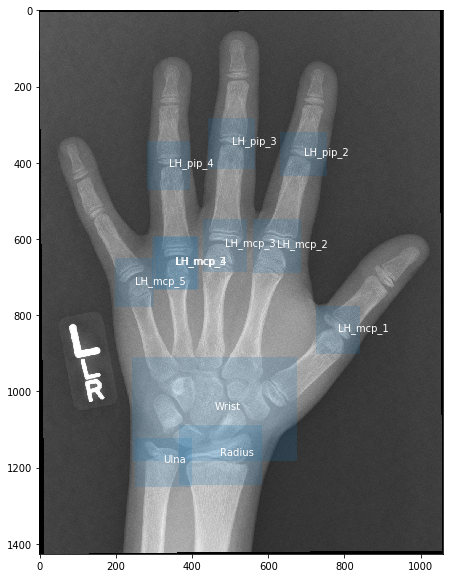

In [92]:
# pick one image from the test set
img, label = dataset[70]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
prediction = prediction[0]
visualize(img, prediction, True)

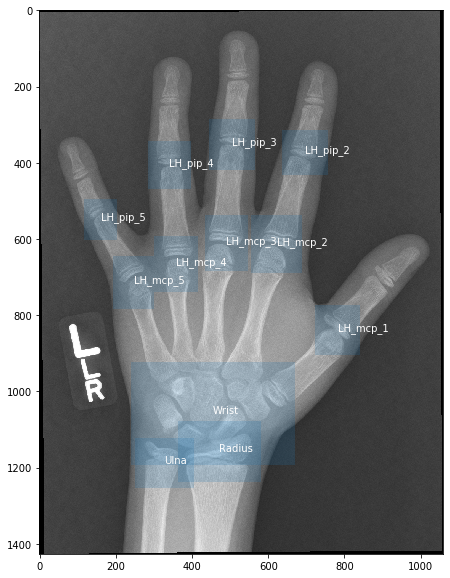

In [89]:
visualize(img, label, True)

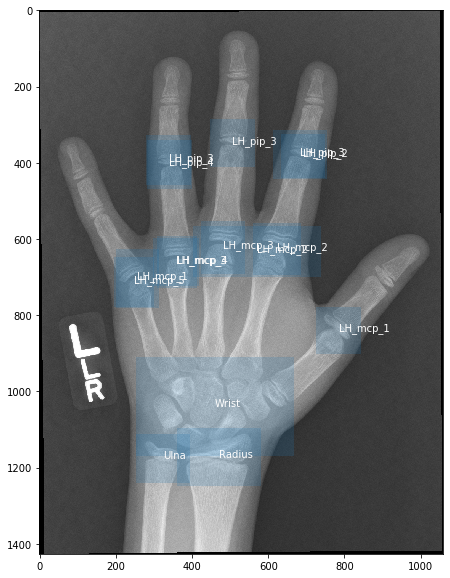

In [58]:
# pick one image from the test set
img, _ = dataset[70]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
visualize(img, prediction, True)

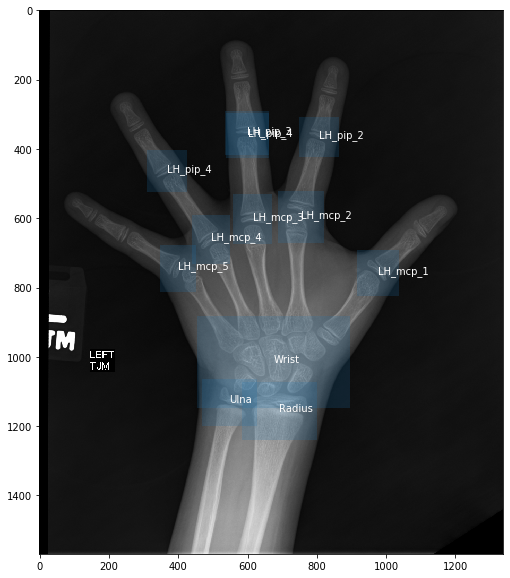

In [95]:
img, _ = dataset[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
prediction = prediction[0]
visualize(img, prediction, True)

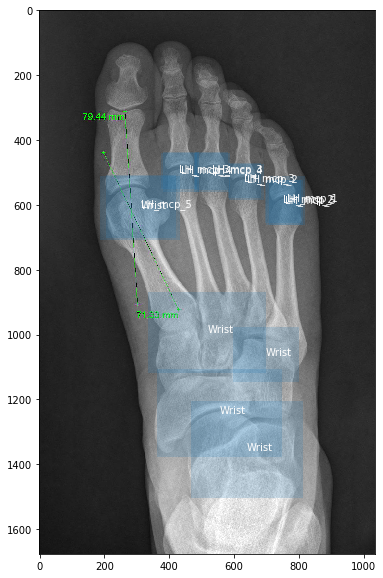

In [108]:
# pick one image fromthe test set
img, _ = ra2_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
visualize(img, prediction[0], True)

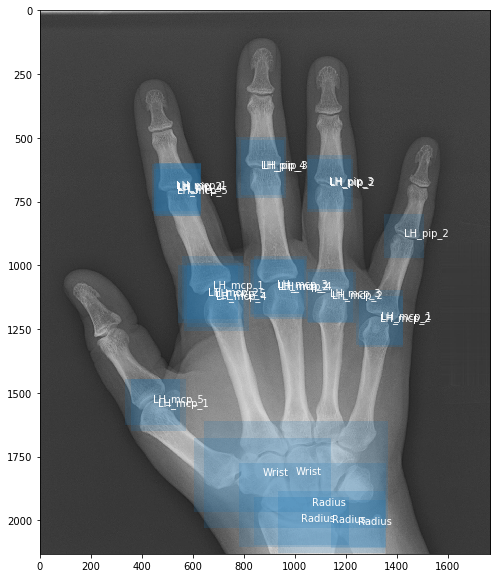

In [75]:
# pick one image fromthe test set
img, _ = ra2_dataset[415]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
visualize(img, prediction, True)

In [ ]:
def visualize(imgs, labels, result = False):
    plt.subplots(nrows = 5, ncols = 5)
    for i in range(25):
        plt.plot()
    if result:
        img = img.mul(255).permute(1,2,0).byte().numpy()
        label = label[0]
    fig,ax = plt.subplots(figsize = (20,10))
    ax.imshow(img)
    for i,box in enumerate(label['boxes']):
        xmin, ymin, xmax, ymax = box.flatten()
        norm = colors.Normalize(vmin=-5, vmax=5)
        cmap = plt.cm.rainbow
        ax.add_patch(Rectangle((xmin,ymin), xmax- xmin,ymax-ymin, alpha = 0.2,color = cmap(norm(label['labels'].cpu()[i]))))
        
#visualize(img, label)

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=1)
for i in range(1, 16):
    ax = fig.add_subplot(6, 4, i)
    ax.imshow(ra2_dataset[i][0].mul(255).permute(1,2,0).byte().numpy(),)

In [ ]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row',figsize = (30,30))
for i in range(2):
    for j in range(2):
        img, _ = ra2_dataset[i*3+j]
        ax[i,j].imshow(img.mul(255).permute(1,2,0).byte().numpy())
        model.eval()
        with torch.no_grad():
            prediction = model([img.to(device)])
        for k,box in enumerate(prediction[0]['boxes']):
            xmin, ymin, xmax, ymax = box.flatten()
            norm = colors.Normalize(vmin=-5, vmax=5)
            cmap = plt.cm.rainbow
            ax[i,j].add_patch(Rectangle((xmin,ymin), xmax- xmin,ymax-ymin, alpha = 0.2,color = cmap(norm(prediction[0]['labels'].cpu()[k]))))
      

In [ ]:
img = Image.open('/home/keane/git/ra2challenge/train/UAB001-LH.jpg').convert("RGB")img, _ = ra2_dataset[8]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
visualize(img, prediction, True)
img = torch.tensor(np.array(img),dtype = torch.float32)

In [ ]:
img = img.permute(2,0,1)

In [ ]:
print(img.shape)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

In [ ]:
img = torch.tensor(np.array(img),dtype = torch.float32)
img.shape

In [ ]:
visualize(img, prediction, True)

In [ ]:
i

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [ ]:
def plot_images(imgs, targets, fname='images.jpg'):
    # Plots training images overlaid with targets
    imgs = imgs.cpu().numpy()
    targets = targets.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    bs, _, h, w = imgs.shape  # batch size, _, height, width
    ns = np.ceil(bs ** 0.5)  # number of subplots

    for i in range(bs):
        boxes = xywh2xyxy(targets[targets[:, 0] == i, 2:6]).T
        boxes[[0, 2]] *= w
        boxes[[1, 3]] *= h
        plt.subplot(ns, ns, i + 1).imshow(imgs[i].transpose(1, 2, 0))
        plt.plot(boxes[[0, 2, 2, 0, 0]], boxes[[1, 1, 3, 3, 1]], '.-')
        plt.axis('off')
    fig.tight_layout()
    fig.savefig(fname, dpi=300)
    plt.close()
plot_images(img,prediction)
    #Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
Image.fromarray(prediction[0]['boxes'][0, 0].mul(255).byte().cpu().numpy())